In [2]:
### This notebook gives a tool to draw the gamma gated proton spectra for some given peaks that can be defined in 
### this notebook. This script uses the files singleproton gamma gated protons which means we are only considering
### events which are within the criteria of the single proton spectra.
### More peaks can be either removed or added easily by modifying the loading of files.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import uproot
import awkward as ak
import os
import scipy.optimize as sc
import glob


In [4]:
data_path = "/home/haue/repositories/Masters/data/singleprotons/Al/"
gam_path = "/home/haue/repositories/Masters/data/gamma/Al/falsebeta/"
g_singlep_path = "/home/haue/repositories/Masters/data/gamma/Al/singlep_gammas"

#outputdir = "/figure_output/"
## Load in all files from the datapath with the suffix mlio.root
Al_files = glob.glob(os.path.join(data_path, "*mlio.root"))
gam_files = glob.glob(os.path.join(gam_path, "*mlio.root"))
g_singlep_files = glob.glob(os.path.join(g_singlep_path, "*mlio.root"))

#Files to be analyzed 
Analysis_files = g_singlep_files


In [5]:
# Define gamma gates and their background regions
peak_gates = {
    "332": [(322, 342), (302, 322), (342, 362)],
    #"445": [(435,455), (415,435), (455, 475)],
    #"735": [(720,750), (690,720), (750,780)],
    #"840": [(828,848), (808,828), (848, 868)],
    #"950": [(935, 965), (905, 935), (965, 995)],
    #"1070":[(1059, 1079), (1039,1059), (1079,1099)],
    "1113": [(1090,1120), (1060,1090), (1120,1150)],
    "1384": [(1366,1396), (1336,1366), (1396,1426)],
    #"1590": [(1580, 1600), (1560,1580), (1580,1600)],
    "1634": [(1620,1650), (1590,1620), (1650,1680)],
    "1716": [(1705,1735), (1675,1705), (1765,1795)],
    "1745": [(1735,1765), (1675,1705), (1765,1795)],
    #"2497": [(2480,2510), (2450,2480), (2510,2540)],
    #"2830": [(2810,2840), (2780,2810), (2840,2870)],

    # can add more gates...
}
# Initialize storage for results
gprotons = {}
region_labels = ["gate", "lower_bg", "upper_bg"]

for gate_name, peak_ranges in peak_gates.items():
    Elist_1 = [np.array([]) for _ in peak_ranges]
    Elist_2 = [np.array([]) for _ in peak_ranges]

    for i, (low, high) in enumerate(peak_ranges):
        
        for batch in uproot.iterate(Analysis_files, expressions=["E"],
            cut=f"(pg1) & (Eg1>{low}) & (Eg1<{high})"):
            Elist_1[i] = np.append(Elist_1[i], ak.flatten(batch.E))

        for batch in uproot.iterate(Analysis_files, expressions=["E"],
            cut=f"(pg2) & (Eg2>{low}) & (Eg2<{high})"):
            Elist_2[i] = np.append(Elist_2[i], ak.flatten(batch.E))

    # Clean and combine
    Elist_1 = [arr[~np.isnan(arr)] for arr in Elist_1]
    Elist_2 = [arr[~np.isnan(arr)] for arr in Elist_2]
    Elist = [np.concatenate((a1, a2)) for a1, a2 in zip(Elist_1, Elist_2)]

    # Store in dictionary with semantic labels
    gprotons[gate_name] = {
        region_labels[i]: Elist[i] for i in range(len(region_labels))
    }
    print(f"Gate: {gate_name} processed succesfully!")

Gate: 332 processed succesfully!
Gate: 1113 processed succesfully!
Gate: 1384 processed succesfully!
Gate: 1634 processed succesfully!
Gate: 1716 processed succesfully!
Gate: 1745 processed succesfully!


In [6]:
### Single proton spectra
E = np.array([])
for batch in uproot.iterate(Al_files, expressions=["E"],
                            cut="(id==3)"):
    E=np.append(E, ak.flatten(batch.E))

In [33]:
####plotter function

def plot_energy_hists(
    energies_list,          # list of arrays of energies (in eV)
    reference_overlay=None, # overlay of comparison spectra
    colors=None,            # list of colors matching energies_list
    labels=None,            # list of labels matching energies_list
    bin_width=0.01,         # bin width in MeV
    scale=None,
    title="Energy Histogram",
    xlabel="Energy (MeV)",
    ylabel="default",
    xlim=(0.25, 8.5),
    fig_ax=None,             # optionally pass existing (fig, ax)
    saveas = None
):
    """
    Plot one or more energy histograms on the same figure with consistent formatting.

    Parameters:
    - energies_list: list of np.arrays, each containing energies (in eV)
    - colors: list of color strings (same length as energies_list), default black if None
    - labels: list of labels (same length as energies_list), default None (no legend)
    - bin_width: float, bin width in MeV
    - title, xlabel, ylabel: strings for the plot
    - xlim: tuple, x-axis limits
    - fig_ax: tuple (fig, ax) if you want to add to existing plot, else None to create new

    Returns:
    - fig, ax: matplotlib figure and axis objects
    """
    bins = np.arange(0, 9 + bin_width, bin_width)
    if fig_ax is None:
        fig, ax = plt.subplots(figsize=(16, 7))
    else:
        fig, ax = fig_ax
    
    if colors is None:
        colors = ['k'] * len(energies_list)
    if labels is None:
        labels = [None] * len(energies_list)
    
    for energies, color, label in zip(energies_list, colors, labels):
        ax.hist(np.array(energies) / 1e3, bins=bins, histtype='step',
                edgecolor=color, color='white', lw=1, label=label)
    
    if reference_overlay is not None:
        overlay_bins = np.arange(0, 9 + 0.01, 0.01)  # fixed 10 keV bins (0.01 MeV)
        ref_hist, ref_edges = np.histogram(np.array(reference_overlay) / 1e3, bins=overlay_bins)
        ref_hist = ref_hist.astype(float)
        ref_max = ref_hist.max()

        # Find max count from main histograms (already computed as global_max later, but for clarity compute here)
        main_max = max([np.histogram(np.array(e) / 1e3, bins=bins)[0].max() for e in energies_list])

        if ref_max > 0:
            if scale is not None:
                # Scale reference histogram only if main max < 1e2
                if main_max < scale:
                    scale_factor = scale / ref_max
                else:
                    scale_factor = main_max / ref_max
                ref_hist_scaled = ref_hist * scale_factor

                ref_bin_centers = (ref_edges[:-1] + ref_edges[1:]) / 2
                ax.hist(ref_bin_centers, bins=ref_edges, weights=ref_hist_scaled, 
            histtype='step', color='r', ls='--', label='Proton spectrum', linewidth=1)
            else:
                # Scale reference histogram only if main max < 1e2
                if main_max < 0:
                    scale_factor = ref_max / ref_max
                else:
                    scale_factor = main_max / ref_max
                ref_hist_scaled = ref_hist * scale_factor

                ref_bin_centers = (ref_edges[:-1] + ref_edges[1:]) / 2
                ax.hist(ref_bin_centers, bins=ref_edges, weights=ref_hist_scaled, 
            histtype='step', color='r', ls='--', label='Proton spectrum', linewidth=1)

            
    ax.set_yscale('log')
    ax.set_xticks(np.arange(0, 8.5, 0.25), minor=True)
    ax.set_xticks(np.arange(0, 8.5, 1))
    ax.set_xlim(*xlim)
    ax.set_xlabel(xlabel, fontsize=16)
    ax.set_title(title, fontsize=16)
    plt.tick_params(axis='y', which='major', direction='in', length=5, width=1, labelsize=14)
    plt.tick_params(axis='y', which='minor', direction='in', length=3, width=1)
    plt.tick_params(axis='x', which='major', direction='in', length=5, width=1, labelsize=14)
    plt.tick_params(axis='x', which='minor', direction='in', length=3, width=1)
    
    if ylabel=="default":
        ax.set_ylabel(f"Counts / {int(bin_width*1000)} keV", fontsize=16)
    else:
        ax.set_ylabel(ylabel, fontsize=16)
    global_max = 0
    for energies in energies_list:
        hist, _ = np.histogram(np.array(energies) / 1e3, bins=bins)
        current_max = hist.max()
        if current_max > global_max:
            global_max = current_max

    # Set log scale and y-limits AFTER main histograms, BEFORE overlay
    if scale!=None:
        ymax = max(global_max, scale)*1.1
    else:
        ymax = max(global_max, 1e2) * 1.1  # Use at least 1e2, scaled a bit
    ax.set_ylim(0.8,ymax)
    if any(labels):
        ax.legend()
    
    if saveas != None:
        plt.savefig(saveas+".pdf")
    return fig, ax


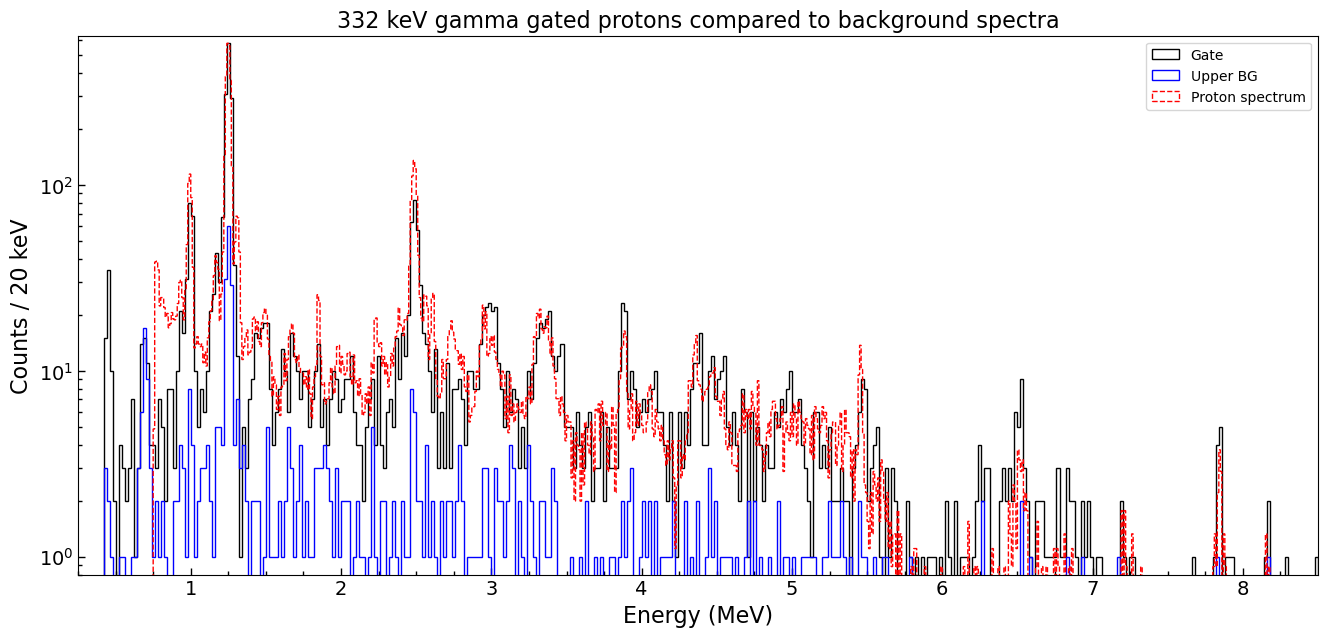

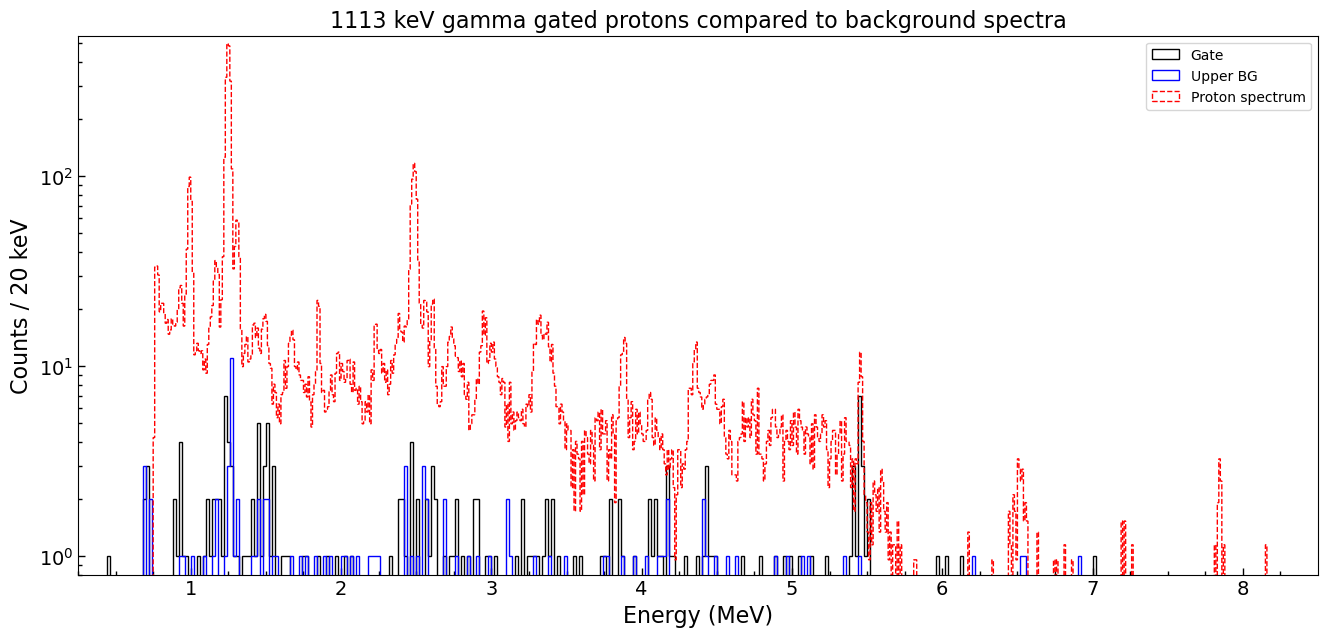

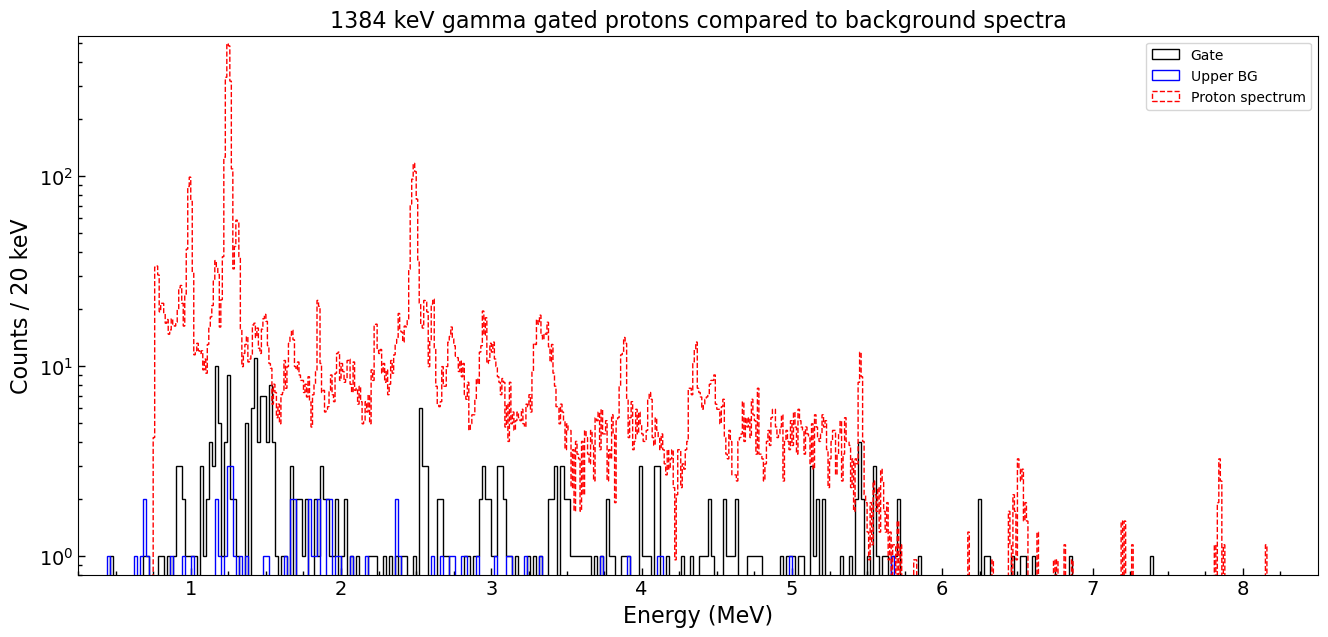

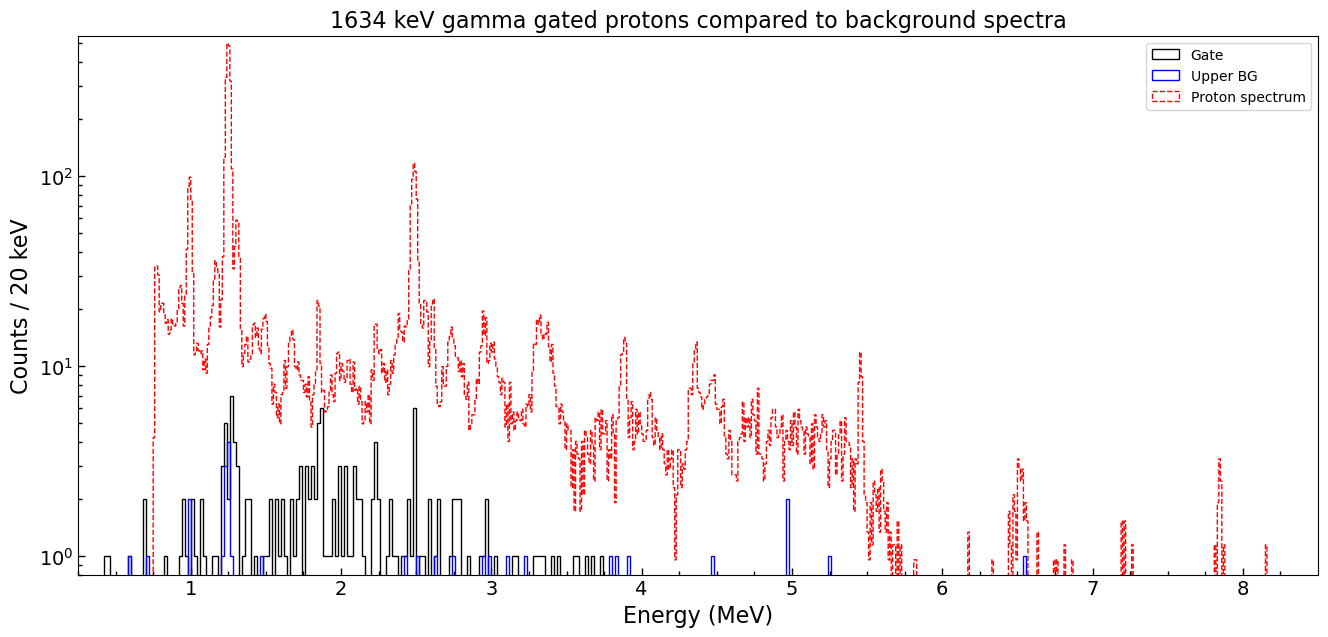

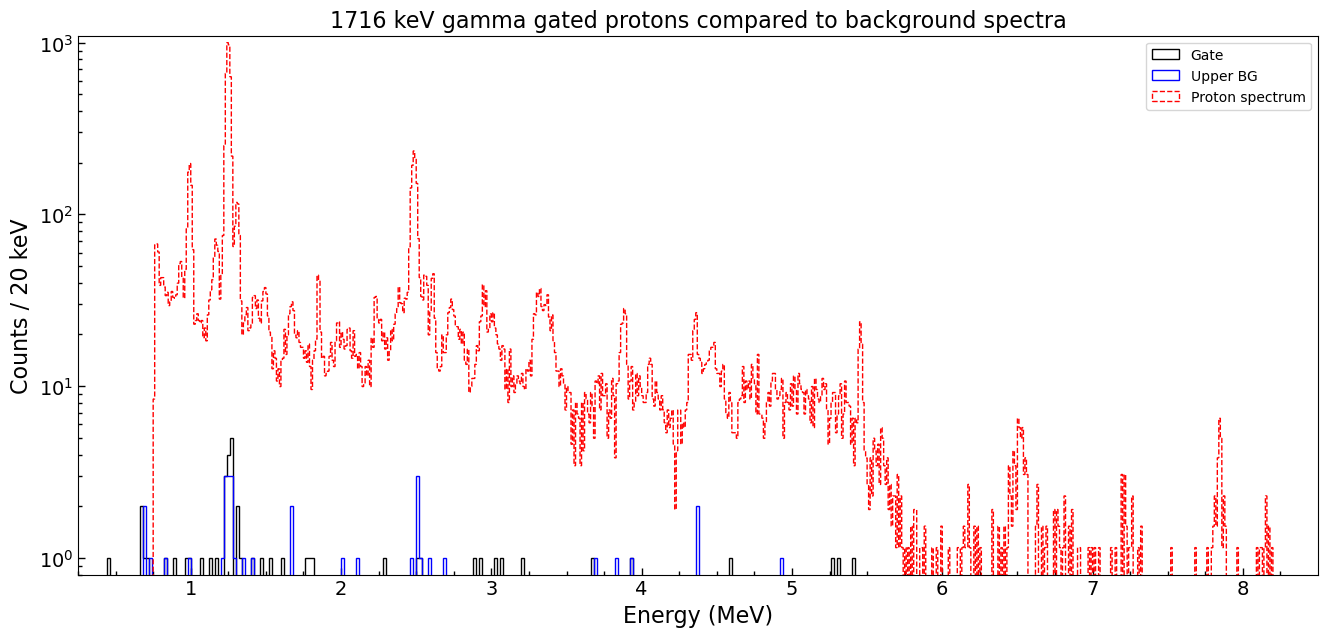

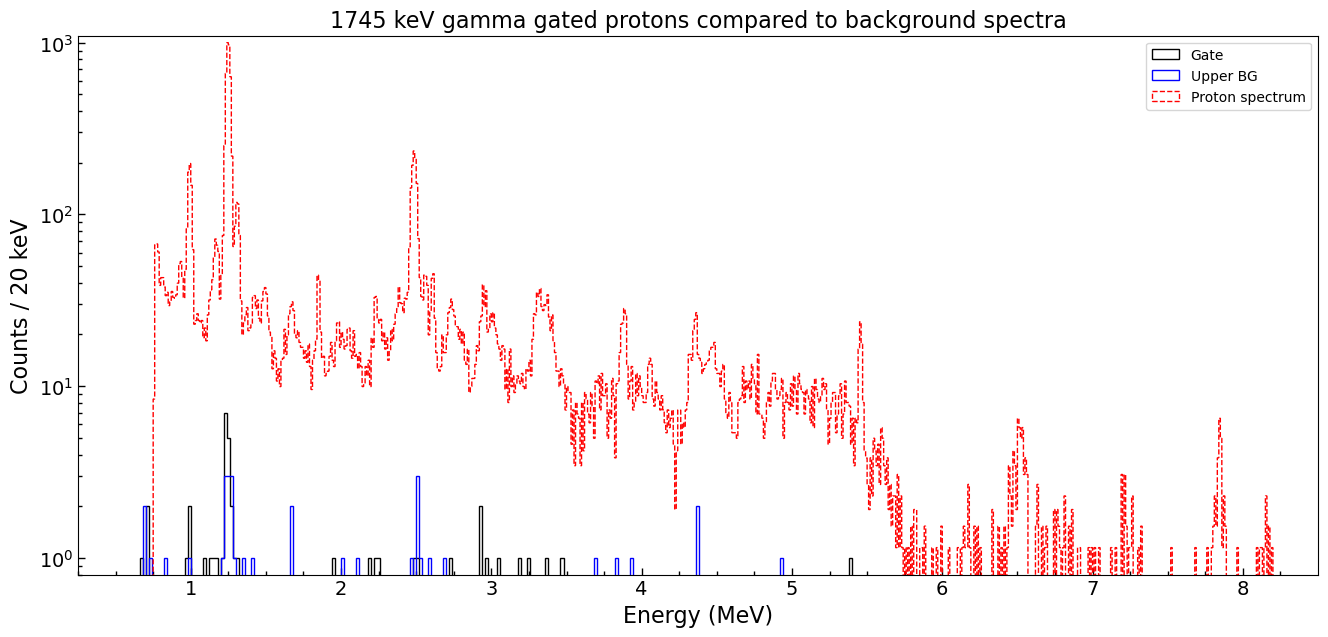

In [34]:

#gates = [332, 445, 735, 840, 950, 1070, 1113, 1384, 1590, 1634, 1716, 1745, 2497, 2830]
gates = [332, 1113, 1384, 1634,1716, 1745]
binwidth = 0.02
scales = [None, 5*1e2, 5*1e2, 5*1e2, 1e3, 1e3]
saves = [None, "1113", "1384", "1634", None, None]
for g,s, sa in zip(gates,scales, saves):
    
    fig, ax = plot_energy_hists(
        energies_list=[gprotons[f"{g}"]["gate"], gprotons[f"{g}"]["upper_bg"]],
        reference_overlay = E,
        colors=['k', 'b', 'r'],
        labels=['Gate','Upper BG'],
        bin_width=binwidth,
        scale=s,
        title=f"{g} keV gamma gated protons compared to background spectra",
        saveas=sa
    )
    plt.show()


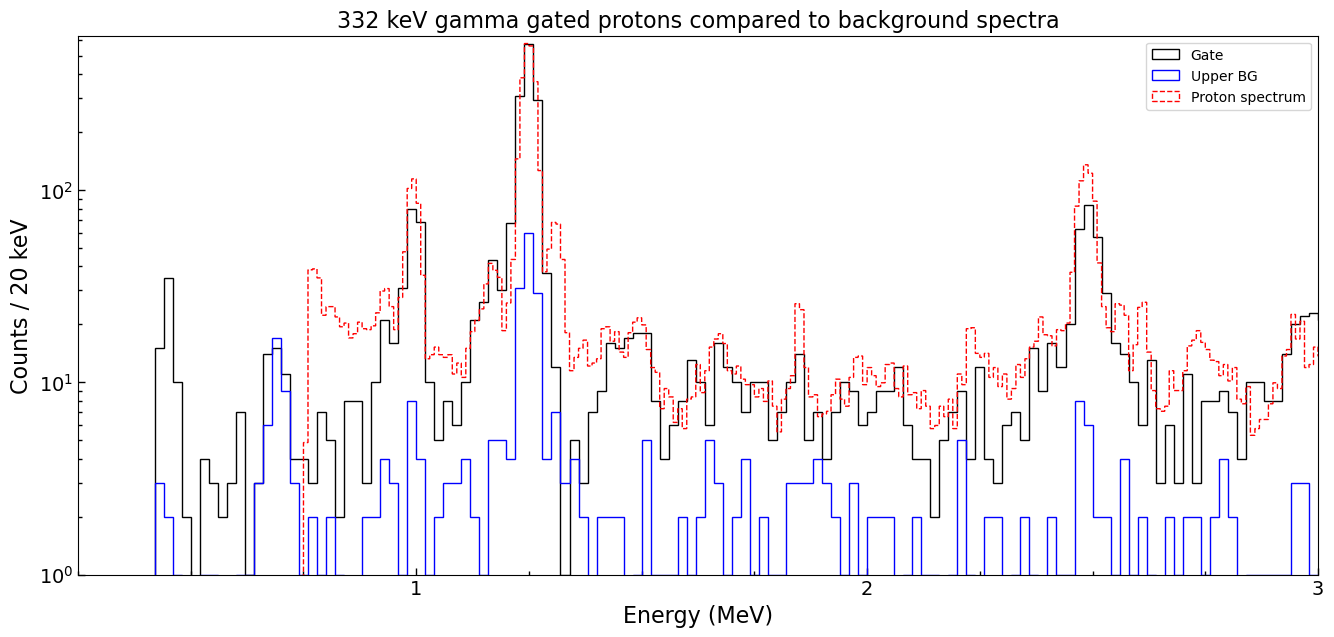

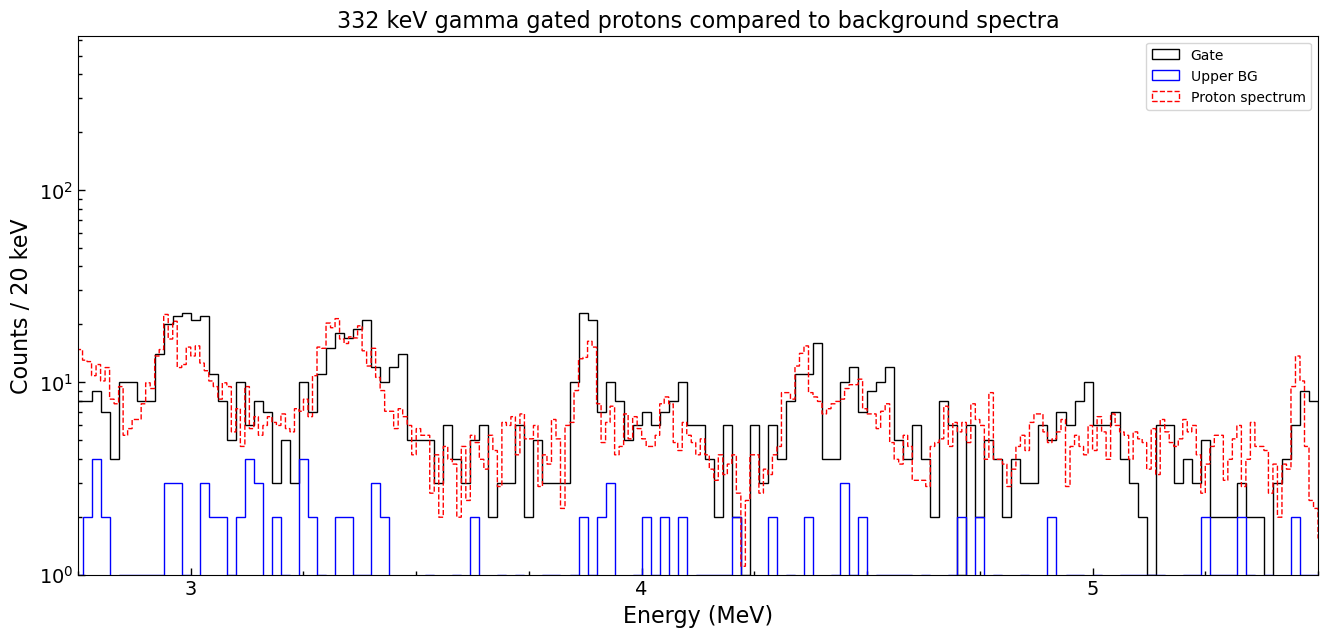

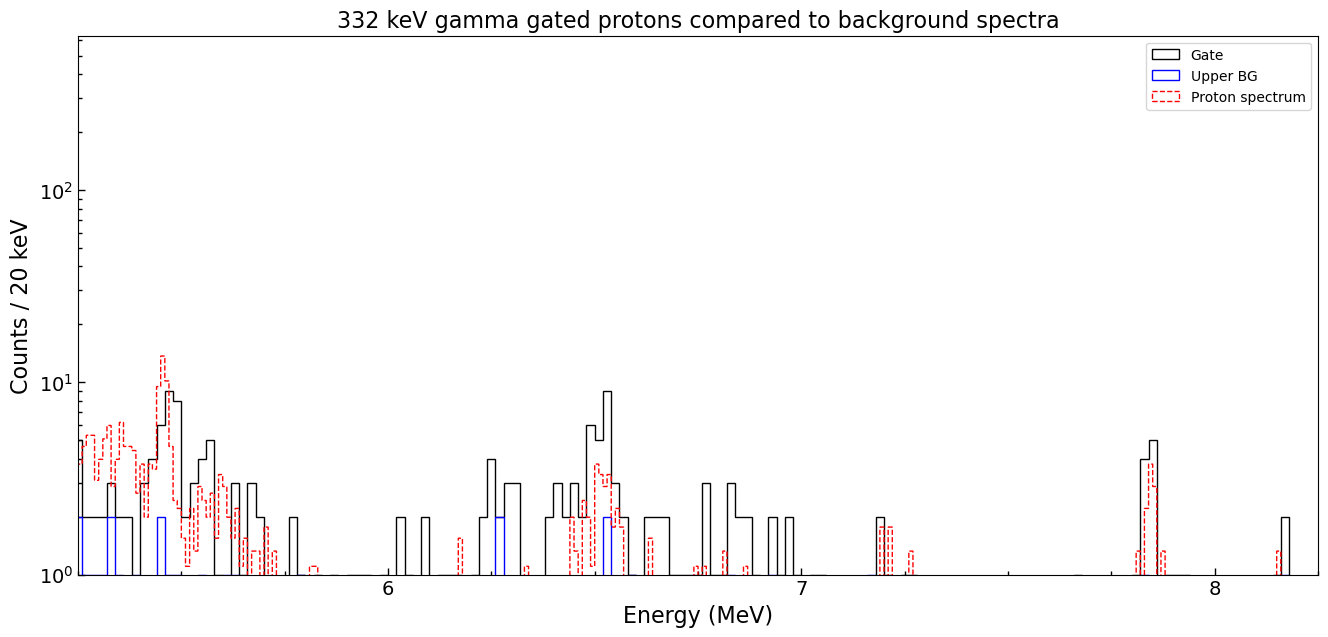

In [29]:

#gates = [332, 445, 735, 840, 950, 1070, 1113, 1384, 1590, 1634, 1716, 1745, 2497, 2830]
gates = [332, 332,332]
binwidth = 0.02
scales = [None, None, None]
xlims = [(0.25,3), (2.75,5.5), (5.25, 8.25)]
saves =["1st", "2nd", "3rd"]
for g,s,xls,sa in zip(gates,scales,xlims,saves):
    
    fig, ax = plot_energy_hists(
        energies_list=[gprotons[f"{g}"]["gate"], gprotons[f"{g}"]["upper_bg"]],
        reference_overlay = E,
        colors=['k', 'b', 'r'],
        labels=['Gate','Upper BG'],
        bin_width=binwidth,
        scale=s,
        title=f"{g} keV gamma gated protons compared to background spectra",
        xlim = xls,
        saveas=sa
    )
